# Labortario 4

Samuel Argueta - 211024

Alejandro Martinez - 21430


In [1]:
# %pip install kaggle
# %pip install opendatasets
# %pip install ydata-profiling

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
import joblib as jl
import pickle
from wordcloud import WordCloud

from textblob import TextBlob
from afinn import Afinn

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams
from nltk import ngrams
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/arg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/arg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/arg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
stop_words = set(stopwords.words('english'))

# Obtencion Data - EDA

In [5]:
# Cargar el conjunto de datos
data = pd.read_csv('./archive/train.csv')
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Se destaca el hecho de tener 5 columnas, de las cuales, 3 poseen informacion valiosa. En este caso, las 2
intermedias poseen datos, pero en filas especificas y no en todas, por ello se ve que hay mayormete NaN.
Estas cols son para palabras que definen, en cierta manera, el tweet y la localidad del tweet.

In [6]:
# Información general del conjunto de datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


# Limpieza data

In [8]:
def eliminar_emoticonos(texto):
    """
    Elimina emojis y otros símbolos de un texto.

    :param texto: El texto del cual se eliminarán los emojis.
    :type texto: str
    :return: El texto sin emojis.
    :rtype: str
    """
    patron_emoticonos = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticonos
        u"\U0001F300-\U0001F5FF"  # símbolos y pictogramas
        u"\U0001F680-\U0001F6FF"  # símbolos de transporte y mapas
        u"\U0001F1E0-\U0001F1FF"  # banderas (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return patron_emoticonos.sub(r'', texto)

def eliminar_palabras_vacias(texto):
    """
    Elimina las palabras vacías (stopwords) de un texto.

    :param texto: El texto del cual se eliminarán las palabras vacías.
    :type texto: str
    :param palabras_vacias: Lista de palabras vacías a eliminar.
    :type palabras_vacias: list
    :return: El texto sin palabras vacías.
    :rtype: str
    """
    palabras = word_tokenize(texto)
    palabras_filtradas = [palabra for palabra in palabras if palabra.lower() not in stop_words]
    return ' '.join(palabras_filtradas)

def obtener_texto_radicado(texto):
    """
    Aplica stemming a cada palabra en el texto, reduciéndolas a su raíz.

    :param texto: El texto que se va a procesar.
    :type texto: str
    :return: El texto con palabras radicadas.
    :rtype: str
    """
    radicador = PorterStemmer()
    palabras = word_tokenize(texto)
    palabras_radicadas = [radicador.stem(palabra) for palabra in palabras]
    return ' '.join(palabras_radicadas)

def aplicar_lemmatizacion(texto):
    """
    Aplica lematización a cada palabra en el texto, reduciéndolas a su forma base o lema.

    :param texto: El texto que se va a lematizar.
    :type texto: str
    :return: El texto con palabras lematizadas.
    :rtype: str
    """
    lematizador = WordNetLemmatizer()
    palabras = word_tokenize(texto)
    palabras_lematizadas = [lematizador.lemmatize(palabra) for palabra in palabras]
    return ' '.join(palabras_lematizadas)

In [9]:
# Hacer todos los textos en minúsculas
data['text'] = data['text'].str.lower()

# Eliminar caracteres especiales “#”,”@” o los apóstrofes
data['text'] = data['text'].str.replace(r'[#@\'"]', '', regex=True)

# Eliminar urls
data['text'] = data['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex=True)

# Eliminar signos de puntuacion
data['text'] = data['text'].str.replace(r'[^\w\s]', '', regex=True)

# Revisar si hay emojis en el texto y luego quitarlos
data['text'] = data['text'].apply(eliminar_emoticonos)

# Quitar los artículos, preposiciones y conjunciones (stopwords)
data['text'] = data['text'].apply(eliminar_palabras_vacias)

# Normalizar las palabras para tratar de convertir todas las palabras encontradas en solo una palabra
data['text'] = data['text'].apply(obtener_texto_radicado)

# Aplicar la función de lematización al atributo 'text
data['text'] = data['text'].apply(aplicar_lemmatizacion)

data

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquak may allah forgiv u,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,resid ask shelter place notifi offic evacu she...,1
3,6,NaN,NaN,13000 peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant crane hold bridg collaps nearbi home,1
7609,10870,NaN,NaN,aria_ahrari thetawniest control wild fire cali...,1
7610,10871,NaN,NaN,m194 0104 utc5km volcano hawaii,1
7611,10872,NaN,NaN,polic investig ebik collid car littl portug eb...,1


# 4.
Obtenga la frecuencia de las palabras tanto de los tweets de desastres como de los que no. ¿Qué
palabras cree que le servirán para hacer un mejor modelo de clasificación?¿vale la pena explorar
bigramas o trigramas para analizar contexto?

In [10]:
# Separar los tweets de desastres y los que no lo son
disasters_tweets = data[data['target'] == 1]['text']
no_disasters_tweets = data[data['target'] == 0]['text']

# Tokenizar los tweets
tokens_disasters = word_tokenize(' '.join(disasters_tweets))
tokens_no_disasters = word_tokenize(' '.join(no_disasters_tweets))

# Calcular la frecuencia de las palabras
freq_disasters = FreqDist(tokens_disasters)
freq_no_disasters = FreqDist(tokens_no_disasters)

# Imprimir las palabras más comunes
print('Palabras más comunes en tweets de desastres:')
for word, frequency in freq_disasters.most_common(20):
    print(f'{word}: {frequency}')

Palabras más comunes en tweets de desastres:
fire: 267
bomb: 180
kill: 158
news: 136
via: 121
flood: 120
disast: 117
california: 115
crash: 112
suicid: 110
train: 109
polic: 107
peopl: 106
amp: 106
famili: 105
u: 104
attack: 104
evacu: 101
like: 101
home: 100


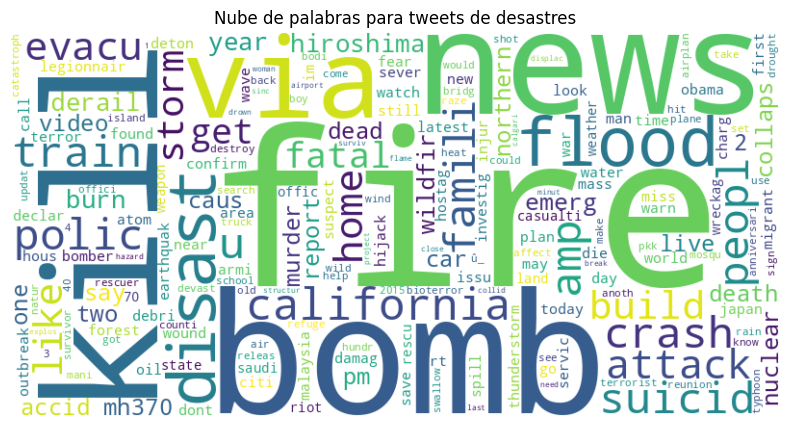

In [11]:
# Crear la nube de palabras para tweets de desastres
wordcloud_disasters = WordCloud(
    background_color='white',
    width=800, height=400,
    max_words=200
).generate_from_frequencies(freq_disasters)

# Mostrar la nube de palabras para tweets de desastres
plt.figure(figsize=(10, 5))
plt.title('Nube de palabras para tweets de desastres')
plt.imshow(wordcloud_disasters, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
print('\nPalabras más comunes en tweets que no son de desastres:')
for word, frequency in freq_no_disasters.most_common(20):
    print(f'{word}: {frequency}')



Palabras más comunes en tweets que no son de desastres:
like: 307
im: 244
get: 223
amp: 192
new: 168
u: 142
go: 142
dont: 141
one: 135
love: 116
bodi: 116
bag: 109
time: 104
video: 102
via: 99
want: 98
see: 98
scream: 98
would: 97
make: 97


# 5. Haga un análisis exploratorio de los datos para entenderlos mejor, documente todos los análisis

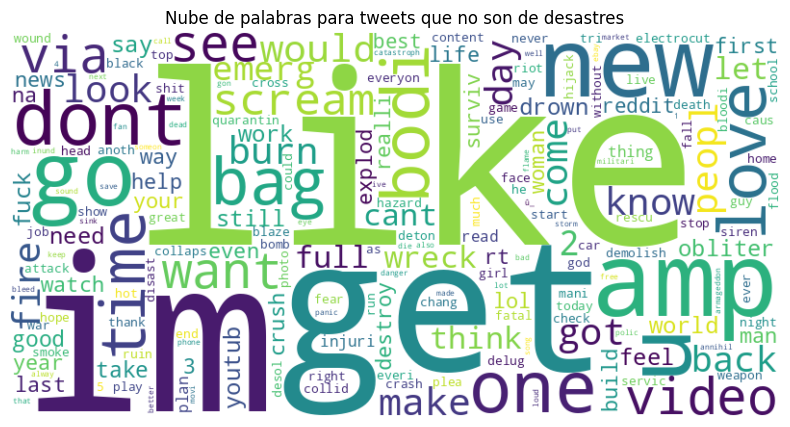

In [13]:
# Crear la nube de palabras para tweets que no son de desastres
wordcloud_no_disasters = WordCloud(
    background_color='white',
    width=800, height=400,
    max_words=200
).generate_from_frequencies(freq_no_disasters)

# Mostrar la nube de palabras para tweets que no son de desastres
plt.figure(figsize=(10, 5))
plt.title('Nube de palabras para tweets que no son de desastres')
plt.imshow(wordcloud_no_disasters, interpolation='bilinear')
plt.axis('off')
plt.show()

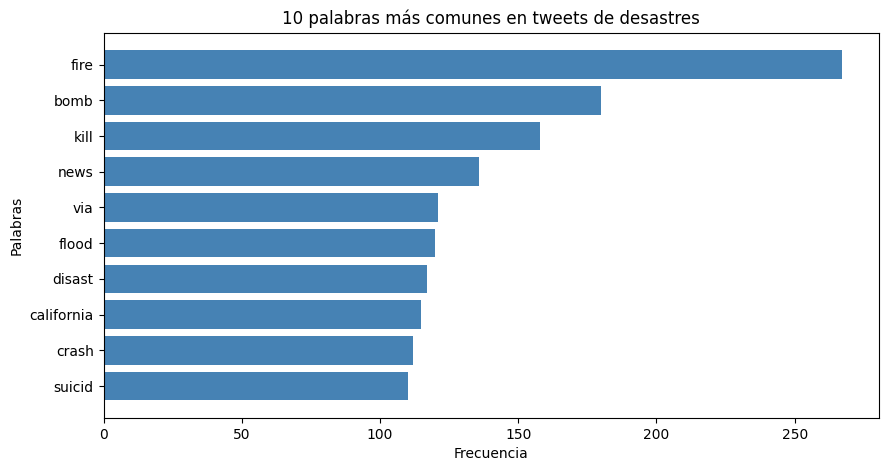

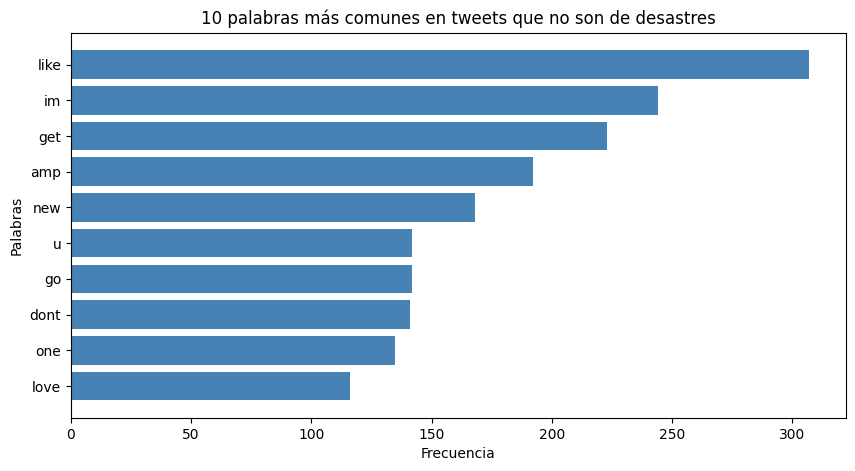

In [14]:
# Separar los tweets de desastres y los que no lo son
disasters_tweets = ' '.join(data[data['target'] == 1]['text'])
no_disasters_tweets = ' '.join(data[data['target'] == 0]['text'])

# Calcular la frecuencia de las palabras para los tweets de desastres
words_disasters = disasters_tweets.split()
word_freq_disasters = Counter(words_disasters)
common_words_disasters = word_freq_disasters.most_common(10)

# Desempaquetar palabras y frecuencias para los tweets de desastres
words_d, frequencies_d = zip(*common_words_disasters)

# Crear el histograma para los tweets de desastres
plt.figure(figsize=(10, 5))
plt.barh(words_d, frequencies_d, color='steelblue')
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('10 palabras más comunes en tweets de desastres')
plt.gca().invert_yaxis()
plt.show()

# Calcular la frecuencia de las palabras para los tweets que no son de desastres
words_no_disasters = no_disasters_tweets.split()
word_freq_no_disasters = Counter(words_no_disasters)
common_words_no_disasters = word_freq_no_disasters.most_common(10)

# Desempaquetar palabras y frecuencias para los tweets que no son de desastres
words_nd, frequencies_nd = zip(*common_words_no_disasters)

# Crear el histograma para los tweets que no son de desastres
plt.figure(figsize=(10, 5))
plt.barh(words_nd, frequencies_nd, color='steelblue')
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('10 palabras más comunes en tweets que no son de desastres')
plt.gca().invert_yaxis()
plt.show()

In [15]:
# Vectorización del texto usando CountVectorizer
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(data['text'])

# Vectorización del texto usando TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['text'])

# La variable objetivo (target)
y = data['target']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Modelos a entrenar
modelos = {
    'Naive Bayes (Count Vectorizer)': MultinomialNB(),
    'Naive Bayes (TF-IDF)': MultinomialNB(),
    'SVM (Count Vectorizer)': LinearSVC(),
    'SVM (TF-IDF)': LinearSVC(),
    'Logistic Regression (Count Vectorizer)': LogisticRegression(max_iter=1000),
    'Logistic Regression (TF-IDF)': LogisticRegression(max_iter=1000),
    'Random Forest (Count Vectorizer)': RandomForestClassifier(),
    'Random Forest (TF-IDF)': RandomForestClassifier(),
}

# Entrenamiento y evaluación de los modelos
for nombre, modelo in modelos.items():
    if 'Count Vectorizer' in nombre:
        modelo.fit(X_train_count, y_train)
        y_pred = modelo.predict(X_test_count)
    else:
        modelo.fit(X_train_tfidf, y_train)
        y_pred = modelo.predict(X_test_tfidf)
    
    print(f"\nModelo: {nombre}")
    print(f"Exactitud: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))



Modelo: Naive Bayes (Count Vectorizer)
Exactitud: 0.8017071569271176
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       874
           1       0.78      0.74      0.76       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.80      1523
weighted avg       0.80      0.80      0.80      1523


Modelo: Naive Bayes (TF-IDF)
Exactitud: 0.8023637557452397
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.83      0.68      0.75       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523


Modelo: SVM (Count Vectorizer)
Exactitud: 0.762967826657912
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       874
           1       0.74      0.69      0.71   

In [19]:
def clasificar_tweet(tweet, modelo, vectorizador):
    """
    Clasifica un tweet en desastre o no desastre usando un modelo entrenado.

    :param tweet: El tweet que se quiere clasificar.
    :type tweet: str
    :param modelo: El modelo de clasificación entrenado.
    :type modelo: sklearn model
    :param vectorizador: El vectorizador usado para transformar el texto.
    :type vectorizador: CountVectorizer or TfidfVectorizer
    :return: Una cadena que indica si el tweet se refiere a un desastre o no.
    :rtype: str
    """
    # Preprocesamiento del tweet (asegurarse de que coincida con el preprocesamiento aplicado a los datos de entrenamiento)
    tweet_procesado = tweet.lower()
    tweet_procesado = re.sub(r'[#@\'"]', '', tweet_procesado)
    tweet_procesado = re.sub(r'http[s]?://\S+', '', tweet_procesado)
    tweet_procesado = re.sub(r'[^\w\s]', '', tweet_procesado)
    tweet_procesado = eliminar_emoticonos(tweet_procesado)
    tweet_procesado = eliminar_palabras_vacias(tweet_procesado)
    tweet_procesado = obtener_texto_radicado(tweet_procesado)
    tweet_procesado = aplicar_lemmatizacion(tweet_procesado)
    
    # Vectorización del tweet
    tweet_vectorizado = vectorizador.transform([tweet_procesado])
    
    # Predicción
    prediccion = modelo.predict(tweet_vectorizado)[0]
    
    if prediccion == 1:
        return "Este tweet se refiere a un desastre."
    else:
        return "Este tweet no se refiere a un desastre."


# Ejemplo de uso de la función
mejor_modelo = modelos['SVM (TF-IDF)']  # Suponiendo que SVM con TF-IDF fue el mejor
vectorizador_usado = tfidf_vectorizer

twt_prueba = "A earthquake just shook the city, buildings collapsed."
resultado = clasificar_tweet(twt_prueba, mejor_modelo, vectorizador_usado)
print(resultado)


Este tweet se refiere a un desastre.
